# Preliminary

Import

In [148]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2

from matplotlib import pyplot as plt

# Model

Model Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout2d(0.25)
    
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

Labels

In [150]:
full_alphabet = 'ABCDEFGHIKLMNOPQRSTUVWXY'
label_mapping = {letter: idx for idx, letter in enumerate(full_alphabet)}
inv_label_mapping = {v: k for k, v in label_mapping.items()}

Load Model

In [151]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(num_classes=24).to(device)

# Ubah berdasarkan path atau nama model
model_name = "cnn_handsign_model_final.pth"

model.load_state_dict(torch.load(model_name, map_location=device))

<All keys matched successfully>

# Inference

Transformasi

In [152]:
test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

Fungsi inferensi

In [153]:
def capture_and_predict():
    cap = cv2.VideoCapture(0)
    print("Tekan 's' untuk take gambar, boxing ROI, ENTER atau SPACE, ESC untuk cancel.")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.flip(frame, 1)
        cv2.imshow("Tekan 's' untuk capture", frame)
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break

    cap.release()
    cv2.destroyAllWindows()

    roi = cv2.selectROI("Boxing ROI", frame, fromCenter=False, showCrosshair=True)
    x, y, w, h = roi
    if w == 0 or h == 0:
        return
    cropped = frame[y:y+h, x:x+w]
    cv2.destroyAllWindows()

    pil_img = Image.fromarray(cropped)
    input_tensor = test_transform(pil_img).unsqueeze(0).to('cuda')

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {inv_label_mapping[pred]}")
    plt.axis('off')
    plt.show()

Running

Tekan 's' untuk take gambar, boxing ROI, ENTER atau SPACE, ESC untuk cancel.
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


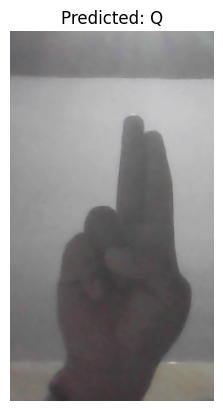

In [154]:
capture_and_predict()